# Linear Regression Analysis

### This notebook fits the house price data with first order linear regression models in order to predict the house sale price using the features that were prepared in the preceding step.

In [1]:
# First import relevant libraries:
import pandas as pd
from sklearn.model_selection import train_test_split # for model validation
import statsmodels.api as sm # for viewing p-values for model coefficients (note that sklearn LinearRegression does not output this information)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load transformed and normalized data:
train_LR = pd.read_csv('train_linear.csv')

#### First iteration of linear regression using all features:

For the intital fitting with a linear model, start by using all of the prepared features. This fit will be done using the OLS function in the statsmodels package because the model fit summary provides p-values for the model coefficients. The plan is to use a manual pseudo-backwards elimination to remove groups of insignificant coefficients with each iteration of the model. Unfortunately, LinearRegression in the sklearn package does not supply p-values, so it cannot be used for this approach.

In [3]:
# Copy train data into new dataframe
train_LR_iter1 = train_LR.copy()

In [4]:
# Obtain a list of column names to split the data into X and y
train_LR_iter1_col_list = train_LR_iter1.columns.tolist()

# The first column is SalePrice (which is y), so store the remaining columns in a dataframe as X
X_LR_iter1 = train_LR_iter1.loc[:,train_LR_iter1_col_list[1]:train_LR_iter1_col_list[-1]] 
# Now store the first column as y
y_LR_iter1 = train_LR_iter1.loc[:,train_LR_iter1_col_list[0]]
# Split data into training and validation sets:
X_LR_iter1_train, X_LR_iter1_validate, y_LR_iter1_train, y_LR_iter1_validate = train_test_split(X_LR_iter1, y_LR_iter1, test_size = 0.2, random_state = 42, shuffle = True)

In [5]:
# Linear regression in statsmodels requires a column corresponding to the constant in the model, so add this column to both the training and validation sets:
X_LR_iter1_train_const = sm.add_constant(X_LR_iter1_train)
X_LR_iter1_validate_const = sm.add_constant(X_LR_iter1_validate)

In [6]:
# Train & fit the model using the training data:
model_LR_iter1 = sm.OLS(y_LR_iter1_train, X_LR_iter1_train_const)
results_LR_iter1 = model_LR_iter1.fit()
# Print results summary
print(results_LR_iter1.summary())

# Define a function to also calculate and print RMSE and R^2 for fits of both the training and validation data
def RMSE_and_R_sq(model_results, X_train_const, X_validate_const, y_train, y_validate):
    # training set:
    y_train_predict = model_results.predict(X_train_const)
    RMSE_train = mean_squared_error(y_train, y_train_predict, squared = False)
    R_squared_train = r2_score(y_train, y_train_predict)
    print('\nThe training set RMSE error is:', round(RMSE_train, ndigits = 4))
    print('The training set R^2 is:', round(R_squared_train, ndigits = 3))
    # validation set:
    y_validate_predict = model_results.predict(X_validate_const)
    RMSE_validate = mean_squared_error(y_validate, y_validate_predict, squared = False)
    R_squared_validate = r2_score(y_validate, y_validate_predict)
    print('\nThe validation set RMSE error is:', round(RMSE_validate, ndigits = 4))
    print('The validation set R^2 is:', round(R_squared_validate, ndigits = 3))
RMSE_and_R_sq(results_LR_iter1, X_LR_iter1_train_const, X_LR_iter1_validate_const, y_LR_iter1_train, y_LR_iter1_validate)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     82.35
Date:                Wed, 19 Oct 2022   Prob (F-statistic):               0.00
Time:                        16:00:00   Log-Likelihood:                 1740.6
No. Observations:                 952   AIC:                            -3255.
Df Residuals:                     839   BIC:                            -2706.
Df Model:                         112                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [7]:
# Define a function to plot model residuals:
def plot_residuals(model_results, y, model_iteration):
    resid = model_results.resid
    resid_plot = pd.concat([y, resid], axis = 1, ignore_index = True)
    resid_plot = resid_plot.rename(columns = {0:'Actual', 1:'Residual'})
    sns.set(rc = {'figure.figsize':(10,8)})
    sns.scatterplot(data = resid_plot, x = 'Actual', y = 'Residual')
    plt.title(f'Linear Regression {model_iteration} Model SalePrice Residuals')
    plt.xlabel('Normalized Actual SalePrice')
    
# Define a fucntion to plot the calculated residuals using the validation set:
def plot_validation_residuals(model_results, X_validate, y_validate, model_iteration):
    predicted = model_results.predict(X_validate)
    resid = y_validate - predicted
    resid_plot = pd.concat([y_validate, resid], axis = 1, ignore_index = True)
    resid_plot = resid_plot.rename(columns = {0:'Actual', 1:'Residual'})
    sns.set(rc = {'figure.figsize':(10,8)})
    sns.scatterplot(data = resid_plot, x = 'Actual', y = 'Residual')
    plt.title(f'Linear Regression {model_iteration} Validation SalePrice Residuals')
    plt.xlabel('Normalized Actual SalePrice')

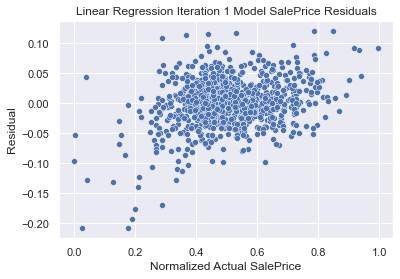

In [8]:
plot_residuals(results_LR_iter1, y_LR_iter1_train, 'Iteration 1')

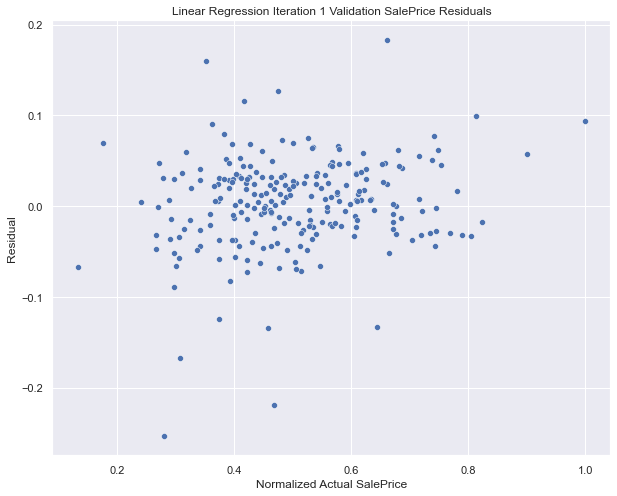

In [9]:
plot_validation_residuals(results_LR_iter1, X_LR_iter1_validate_const, y_LR_iter1_validate, 'Iteration 1')

Alright, let's analyze the results from the first iteration:
- Firstly, the second note at the end of the results summary indicates that there are (at least) two features that are describing the same property. The features responsible for this are BsmtQual & BsmtCond, since both of these were encoded to have a value for no basement ('None'). One of these two features should be dropped. Although not shown here, it was found the regression model fits were slightly better including BsmtQual, so BsmtCond will be removed in the subsequent iterations of the model.
    - Technically fireplaces have two analogous features, but as indicated below, one of these will be removed for another reason.
- For the first round of coefficient pruning, 90% confidence will be used for the cutoff. The next round will use 95% confidence as the cutoff. There are several coefficients that are  not significant at 90% confidence (p > 0.10):
    - LotFrontage, LotShape, RoofStyle Exterior1st, MasVnrType, ExterQual, FullBath, FireplaceQu, MoSold
- The residual plot shows the model does a reasonably good job fitting the training, _except_ at the lower end of the range of sale prices. The residual plot using the validation set mostly agrees.

#### Second iteration of linear regression with some features removed:

In [10]:
# Copy the training data once again into a new dataframe
train_LR_iter2 = train_LR.copy()

In [11]:
# Store a list of the features that are not significant in a tuple
LR_iter2_insig = ('LotFrontage', 'RoofStyle', 'LotShape', 'Exterior1st', 'ExterQual', 'FireplaceQu', 'BsmtCond')
# Use this tuple to remove these features from the data set
train_LR_iter2 = train_LR_iter2.loc[:,~train_LR_iter2.columns.str.startswith(LR_iter2_insig)]

In [12]:
# Once again, obtain a list of column names to split the data into X and y
train_LR_iter2_col_list = train_LR_iter2.columns.tolist()

# The first column is SalePrice (which is y), so store the remaining columns in a dataframe as X
X_LR_iter2 = train_LR_iter2.loc[:,train_LR_iter2_col_list[1]:train_LR_iter2_col_list[-1]] 
# Now store the first column as y
y_LR_iter2 = train_LR_iter2.loc[:,train_LR_iter2_col_list[0]]
# Split data into training and validation sets:
X_LR_iter2_train, X_LR_iter2_validate, y_LR_iter2_train, y_LR_iter2_validate = train_test_split(X_LR_iter2, y_LR_iter2, test_size = 0.2, random_state = 42, shuffle = True)

In [13]:
# Add the constant column to both the training and validation sets:
X_LR_iter2_train_const = sm.add_constant(X_LR_iter2_train)
X_LR_iter2_validate_const = sm.add_constant(X_LR_iter2_validate)

In [14]:
# Train & fit the model using the training data:
model_LR_iter2 = sm.OLS(y_LR_iter2_train, X_LR_iter2_train_const)
results_LR_iter2 = model_LR_iter2.fit()
# Print results summary
print(results_LR_iter2.summary())
# Call the function to print RMSE & R^2 values
RMSE_and_R_sq(results_LR_iter2, X_LR_iter2_train_const, X_LR_iter2_validate_const, y_LR_iter2_train, y_LR_iter2_validate)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     99.35
Date:                Wed, 19 Oct 2022   Prob (F-statistic):               0.00
Time:                        16:00:00   Log-Likelihood:                 1726.4
No. Observations:                 952   AIC:                            -3267.
Df Residuals:                     859   BIC:                            -2815.
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

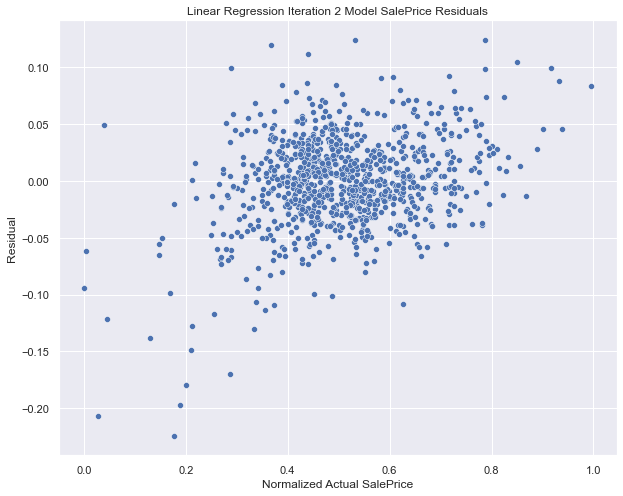

In [15]:
# Call the function to plot the residuals
plot_residuals(results_LR_iter2, y_LR_iter2_train, 'Iteration 2')

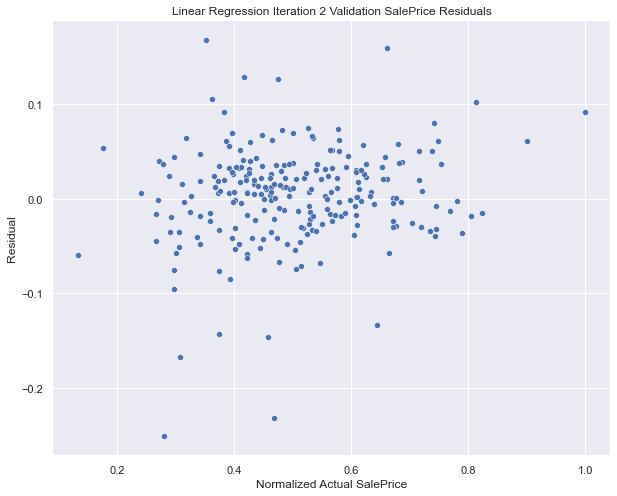

In [16]:
# Also call the function to plot the residuals using the validation set:
plot_validation_residuals(results_LR_iter2, X_LR_iter2_validate_const, y_LR_iter2_validate, 'Iteration 2')

Analysis of second iteration results:
- There is no longer a note about collinearity, so that issue was resolved by removing BsmtCond from the model.
- There are a few more coefficients that are now not significant at 95% confidence:
    - LotConfig, MasVnrType, Fireplaces
- The RMSE and R<sup>2</sup> metrics both suggest this fit is slightly inferior than the first iteration.
- The residual plots are basically unchanged from the first iteration.

#### Third iteration of linear regression with more features removed:

In [17]:
# Copy the training data once again into a new dataframe
train_LR_iter3 = train_LR.copy()

In [18]:
# Append tuple with insignificant features with those observed to be not significant with second iteration of model
LR_iter3_insig = ('LotFrontage', 'RoofStyle', 'LotShape', 'Exterior1st', 'ExterQual', 'FireplaceQu', 'BsmtCond', 'LotConfig','MasVnrType','Fireplaces')
# Use this tuple to remove these features from the data set
train_LR_iter3 = train_LR_iter3.loc[:,~train_LR_iter3.columns.str.startswith(LR_iter3_insig)]

In [19]:
# Once again, obtain a list of column names to split the data into X and y
train_LR_iter3_col_list = train_LR_iter3.columns.tolist()

# The first column is SalePrice (which is y), so store the remaining columns in a dataframe as X
X_LR_iter3 = train_LR_iter3.loc[:,train_LR_iter3_col_list[1]:train_LR_iter3_col_list[-1]] 
# Now store the first column as y
y_LR_iter3 = train_LR_iter3.loc[:,train_LR_iter3_col_list[0]]
# Split data into training and validation sets:
X_LR_iter3_train, X_LR_iter3_validate, y_LR_iter3_train, y_LR_iter3_validate = train_test_split(X_LR_iter3, y_LR_iter3, test_size = 0.2, random_state = 42, shuffle = True)

In [20]:
# Add the constant column to both the training and validation sets:
X_LR_iter3_train_const = sm.add_constant(X_LR_iter3_train)
X_LR_iter3_validate_const = sm.add_constant(X_LR_iter3_validate)

In [21]:
# Train & fit the model using the training data:
model_LR_iter3 = sm.OLS(y_LR_iter3_train, X_LR_iter3_train_const)
results_LR_iter3 = model_LR_iter3.fit()
# Print results summary
print(results_LR_iter3.summary())
# Call the function to print RMSE & R^2 values
RMSE_and_R_sq(results_LR_iter3, X_LR_iter3_train_const, X_LR_iter3_validate_const, y_LR_iter3_train, y_LR_iter3_validate)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     105.4
Date:                Wed, 19 Oct 2022   Prob (F-statistic):               0.00
Time:                        16:00:01   Log-Likelihood:                 1719.6
No. Observations:                 952   AIC:                            -3265.
Df Residuals:                     865   BIC:                            -2842.
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

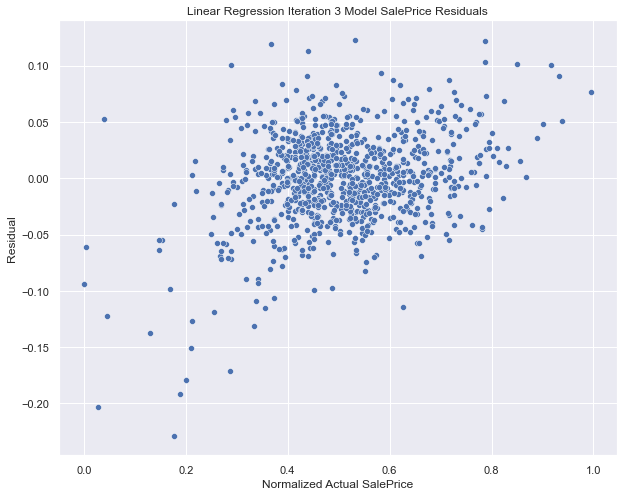

In [22]:
# Call the function to plot the residuals
plot_residuals(results_LR_iter3, y_LR_iter3_train, 'Iteration 3')

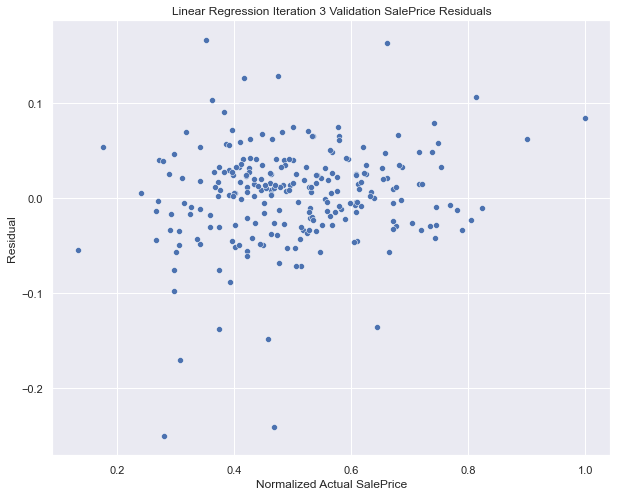

In [23]:
# Also call the function to plot the residuals using the validation set:
plot_validation_residuals(results_LR_iter3, X_LR_iter3_validate_const, y_LR_iter3_validate, 'Iteration 3')

Analysis of the third iteration of the linear regression model:
- All of the remaining coefficients are or (in the case of categorical features) have at least one level that is significant at 95% confidence.
- The RMSE and R<sup>2</sup> metrics both suggest this fit is inferior to the second iteration. The increase in RMSE is larger going from the 2<sup>nd</sup> -> 3<sup>rd</sup> iteration than from the 1<sup>st</sup> -> 2<sup>nd</sup>. This may indicate removing additional terms did not help the model fit.
- The residual plots are basically unchanged from the first iteration.

#### Summary of the validation set R<sup>2</sup>, RMSE, and test set score:

| Model Iteration | Validation R<sup>2</sup> | Validation RMSE | Test Set Score (log RMSE) |
| --- | -: | -: | -: |
| Iteration 1 | 0.864 | 0.0506 | 0.15089 |
| Iteration 2 | 0.862 | 0.0509 | 0.15070 |
| Iteration 3 | 0.860 | 0.0515 | 0.15130 |

Interestly, it was the second iteration of the linear regression model that resulted in the best (lowest) score with the test set, suggesting that neither of these metrics is perfectly predicting the model performance. It does appear, however, that the validation RMSE is trending closer to the test set score. (It should be, since the test score is based on the RMSE difference between the logarithm of the predicted sale price and the logarithm of the actual sale price.)

Let's examine at the coefficient magnitudes of from the 2<sup>nd</sup> iteration of the linear regression model to see which features impact sale price the greatest.

In [24]:
# First get coefficients (params) from regression model
coeff_LR_iter2 = results_LR_iter2.params
# Take absolute value since magnitude is of interest
coeff_LR_iter2_abs = abs(coeff_LR_iter2)
# Sort by absolute value and then only display the ten coefficients with the greatest impact to sale price
coeff_LR_iter2_df = pd.DataFrame({'Coeff':coeff_LR_iter2, 'abs(Coeff)':coeff_LR_iter2_abs})
coeff_LR_iter2_df_sorted = coeff_LR_iter2_df.sort_values(by = 'abs(Coeff)', ascending = False)
coeff_LR_iter2_df_sorted.drop(columns = 'abs(Coeff)').head(10)

,Coeff
GrLivArea,0.403603
OverallQual,0.195692
LotArea,0.164327
MSZoning_RH,0.145377
MSZoning_FV,0.135606
const,-0.131813
MSZoning_RM,0.119804
MSZoning_RL,0.119341
BsmtQual_None,-0.068850
KitchenQual_Fair,-0.062682


The top three coefficients that (positively) affect sale price are probably the not much of a surpise: house square footage (by a large margin), followed by the house quality and lot size. After these continuous predictors are all of the levels for the zoning classification. Interestingly, none of the levels for the neighborhood feature are in the top ten, which suggests that the housing density impacts house sale price more than where the home is located if the housing density is the same.

So from this model, the key factors for house price can be described as house/lot size, quality, and housing density (or proximity with neighbors). It's worth noting that lot size is also probably a function of housing density (zoning).

#### This concludes the linear regression analysis. Now let's see if including higher order terms (squared and interaction terms) can improve how well the model can fit the data.